In [5]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [6]:
import os
import gc
import sys
srcpath = os.path.realpath('./../SourceFiles')
sys.path.append(srcpath)
#from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from pulse_sequencev2 import EPR_pulse

In [4]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = '169.254.18.140' #Proteus Lan

inst = TEVisaInst(inst_addr)

resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp)
# The paranoia-level is either 
# low (0), normal (1) or debug (2)
paranoia_level = 2

print ('Reset instrument ..')

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

dac_mode = 16 

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

# scaling
max_dac = 2 ** dac_mode - 1
half_dac = max_dac / 2.0
wpt_type = np.uint16   

    
# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

sampleRateDAC = 2.5E9
cmd = ':FREQ:RAST {0}'.format(sampleRateDAC) 
inst.send_scpi_cmd(cmd)

print('Done')

connected to: Tabor Electronics,P2582D,000002248484,1.237.0 --slot#: 5, 
Reset instrument ..
Model: P2582D 
Available memory per DDR: 4,286,532,544 wave-bytes
Done


In [10]:
def generate_phasecycled_sequences(pulse_gen, base_sequence, phase_list):
    """
    Generate a list of (t, y) sequences for each set of phase values.

    Parameters:
        pulse_gen : EPR_pulse
            An instance of your EPR_pulse class.
        base_sequence : list of tuples
            Base sequence with phase placeholders in each pulse step.
        phase_list : list of lists
            Each sublist corresponds to [phase1, phase2, ...] for one full cycle.

    Returns:
        List of (t, y) pairs, one for each phase cycle.
    """
    all_sequences = []

    for phase_set in phase_list:
        steps = []
        pulse_idx = 0
        for pulse_type, duration, params in base_sequence:
            params_copy = params.copy()
            if pulse_type.lower() != 'delay':
                params_copy['phase'] = phase_set[pulse_idx]
                pulse_idx += 1
            steps.append((pulse_type, duration, params_copy))

        t_seq, y_seq, y_det = pulse_gen.pulse_sequence(steps)
        all_sequences.append((t_seq, y_seq, y_det))

    return all_sequences



pulse = EPR_pulse(sampling_rate=2.5e9, Vpp=1)

# Base sequence (2 pulses + 2 delays), no phase filled in yet
base_seq = [
    ('Gaussian', 20e-6, {'amplitude': 1, 'f_c': 0e6}),  # P1
    ('delay',    10e-6,{}),                                 # dt
    ('Square',   20e-6, {'amplitude': 1, 'f_c': 0.05e6}),  # P2
    ('delay',    10e-6,{}),
    ('detection',   20e-6, {'amplitude': 1, 'f_c': .05e6}),  # P2

]

phase_cycle = [
    [0, 0, 90],
    [90, 90,100],
    [180, 0,200],
    [270, 0,160],
    [0,0,0]
]

sequences = generate_phasecycled_sequences(pulse, base_seq, phase_cycle)

# Optional: Convert to DAC or dig_output
for i, (t,y,d) in enumerate(sequences):
    y_dac = pulse.DAC_output(np.real(y))  # optional: real part only
    # OR: t, dig = pulse.dig_output(...) if you want binary output
    print(f"Cycle {i}: {len(t)} samples, duration {t[-1]*1e9:.1f} ns")

Cycle 0: 200000 samples, duration 79999.6 ns
Cycle 1: 200000 samples, duration 79999.6 ns
Cycle 2: 200000 samples, duration 79999.6 ns
Cycle 3: 200000 samples, duration 79999.6 ns
Cycle 4: 200000 samples, duration 79999.6 ns


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


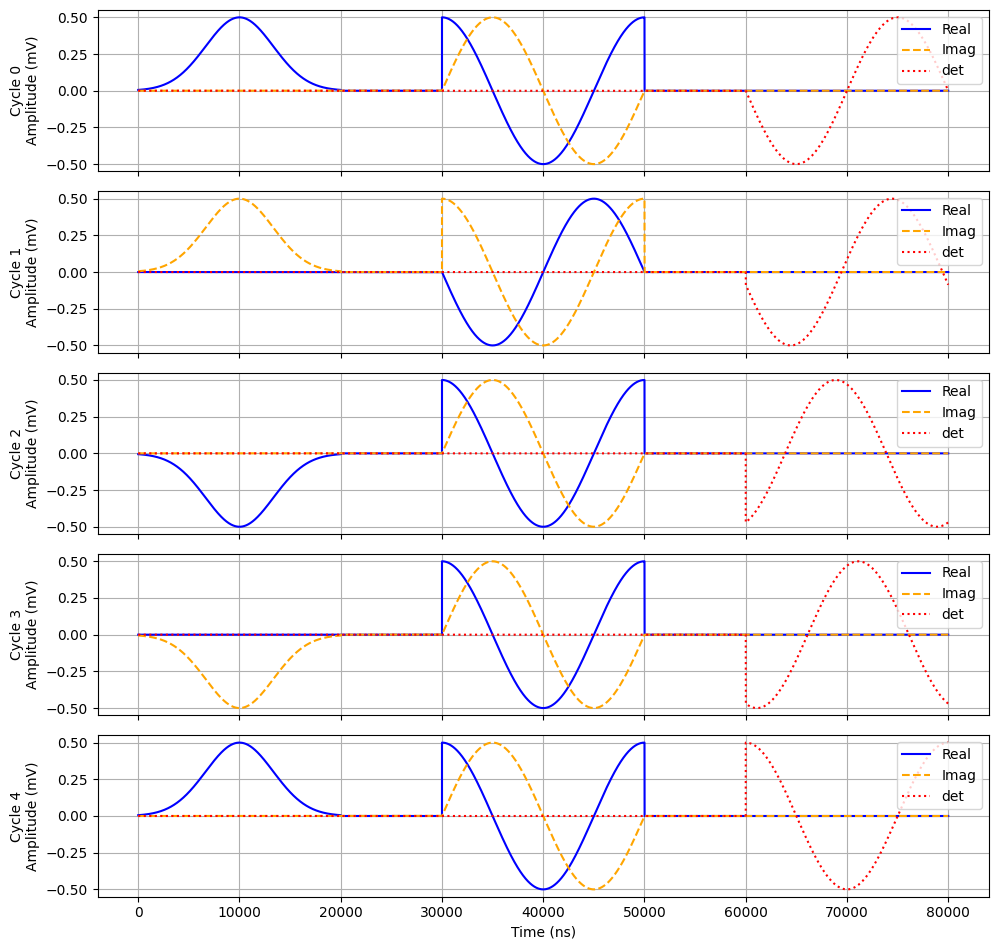

In [15]:
%matplotlib inline
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, (t, y,d) in enumerate(sequences):
    axs[i].plot(t * 1e9, np.real(y), label='Real', color='blue')
    axs[i].plot(t * 1e9, np.imag(y), label='Imag', color='orange', linestyle='--')
    axs[i].plot(t * 1e9, d, label='det', color='red', linestyle=':')

    axs[i].set_ylabel(f'Cycle {i}\nAmplitude (mV)')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (ns)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()